In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from PIL import Image
import math
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
img_size=48

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path='images/fer2013/train'
val_path='images/fer2013/valid'

Train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
) 

Test_datagen = ImageDataGenerator(
    rescale=1./255
) 

In [5]:
Train_generator=Train_datagen.flow_from_directory(train_path,target_size=(img_size,img_size),batch_size=64,class_mode='categorical')

Found 28715 images belonging to 7 classes.


In [6]:
Val_generator=Test_datagen.flow_from_directory(val_path,target_size=(img_size,img_size),batch_size=64,class_mode='categorical')

Found 3589 images belonging to 7 classes.


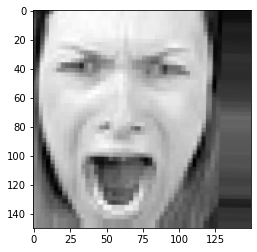

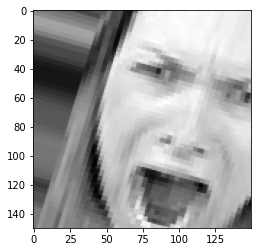

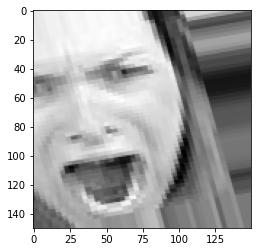

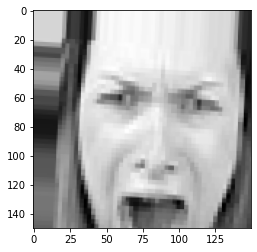

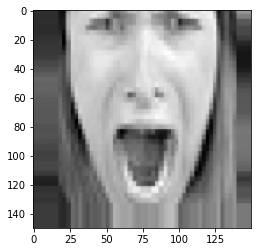

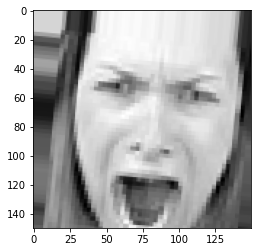

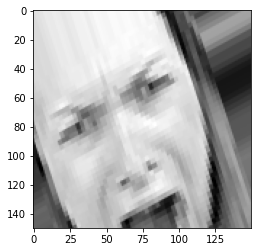

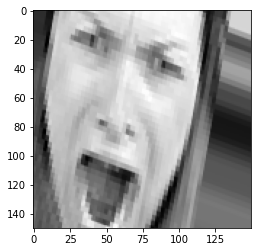

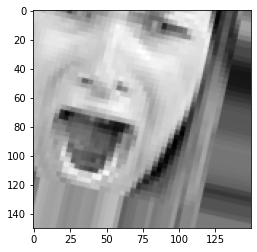

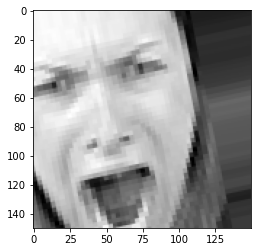

In [7]:
# test Train_datagen performance
from tensorflow.keras.preprocessing import image # 影象預處理模組

train_path_soft='images/fer2013/train/Angry'

fnames = [os.path.join(train_path_soft, fname) for fname in os.listdir(train_path_soft)]
img_path = fnames[3] # 選擇一張圖片進行增強
img = image.load_img(img_path, target_size=(150, 150)) # 讀取影象並調整大小
x = image.img_to_array(img) # 形狀轉換為(150,150,3)的Numpy陣列
x = x.reshape((1,) + x.shape)

i = 0
# 生成隨機變換後圖像批量，迴圈是無限生成，也需要我們手動指定終止條件
for batch in Train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 10 == 0:
        break
plt.show()

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

model=models.Sequential()
model.add(layers.Conv2D(64,(7,7),strides=1,padding='same',activation='relu',input_shape=(img_size,img_size,3),kernel_initializer='he_normal'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(256,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
#model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(1024,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
model.add(layers.Conv2D(1024,(3,3),padding='same',activation='relu',kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(240,activation='relu',kernel_initializer='he_normal'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7,activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)       5

In [10]:
import tensorflow as tf 

In [11]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

In [13]:
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_12_03-20_47_23'

In [14]:
modelName=run_logdir[10:]+".h5"

In [15]:
checkpoint_cb=ModelCheckpoint(modelName, save_best_only=True)

In [16]:
early_stopping_cb = EarlyStopping(patience=10,restore_best_weights=True)

In [17]:
tensorboard_cb = TensorBoard(run_logdir)

In [18]:
history=model.fit_generator(
    Train_generator,
    steps_per_epoch=len(Train_generator),
    #steps_per_epoch=15779//batch_size+1,
    epochs=500,
    validation_data=Val_generator,
    validation_steps=len(Val_generator),
    #callbacks=[checkpoint_cb, early_stopping_cb,tensorboard_cb]
    callbacks=[checkpoint_cb, early_stopping_cb,tensorboard_cb]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
  1/449 [..............................] - ETA: 0s - loss: 2.1083 - accuracy: 0.1562WARNING:tensorflow:From /home/highsunday/anaconda3/envs/python_yolo/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
449/449 [==============================] - 39s 87ms/step - loss: 1.8151 - accuracy: 0.2412 - val_loss: 2.9062 - val_accuracy: 0.1206
Epoch 2/500
449/449 [==============================] - 23s 51ms/step - loss: 1.8001 - accuracy: 0.2437 - val_loss: 2.5934 - val_accuracy: 0.1845
Epoch 3/500
449/449 [==============================] - 23s 51ms/step - loss: 1.7948 - accuracy: 0.2527 - val_loss: 2.4868 - val_accuracy: 0.1931
Epoch 4/500
449/449 [==============================] - 23s 51ms/step - loss: 1.7873 - accuracy

Epoch 51/500
449/449 [==============================] - 20s 46ms/step - loss: 0.9788 - accuracy: 0.6334 - val_loss: 1.0319 - val_accuracy: 0.6367
Epoch 52/500
449/449 [==============================] - 21s 46ms/step - loss: 0.9723 - accuracy: 0.6337 - val_loss: 7.7649 - val_accuracy: 0.6434
Epoch 53/500
449/449 [==============================] - 21s 46ms/step - loss: 0.9714 - accuracy: 0.6344 - val_loss: 10.0583 - val_accuracy: 0.5561
